# Main

## Define variables and import the main library

In [1]:
project_directory = '/data/BIDS-HPC/private/projects/dmi2'
import os, sys
links_dir = os.path.join(project_directory, 'data', 'all_gene_expression_files_in_target', 'links')
annotation_file = os.path.join(project_directory, 'data', 'gencode.v22.annotation.gtf')
sample_sheet_file = os.path.join(project_directory, 'data', 'gdc_sample_sheet.2020-07-02.tsv')
metadata_file = os.path.join(project_directory, 'data', 'metadata.cart.2020-07-02.json')
if os.path.join(project_directory, 'checkout') not in sys.path:
    sys.path.append(os.path.join(project_directory, 'checkout'))
import target_class_lib as tc

## Load the data downloaded from the GDC Data Portal

In [2]:
df_samples, df_counts = tc.load_gdc_data(sample_sheet_file, metadata_file, links_dir)

Reading pickle file /data/BIDS-HPC/private/projects/dmi2/data/gdc_data.pkl...


## Calculate the FPKM and FPKM-UQ dataframes, and check them with known values if the needed datafiles are present

In [3]:
df_fpkm, df_fpkm_uq = tc.get_fpkm(df_counts, annotation_file, df_samples, links_dir)

Reading pickle file /data/BIDS-HPC/private/projects/dmi2/data/fpkm_data.pkl...


## Remove from the samples and intensities the samples that correspond to multiple cases (i.e., people)

In [4]:
df_samples, indexes_to_keep, _ = tc.drop_multiperson_samples(df_samples)
df_counts = df_counts.iloc[indexes_to_keep,:]
df_fpkm = df_fpkm.iloc[indexes_to_keep,:]
df_fpkm_uq = df_fpkm_uq.iloc[indexes_to_keep,:]

Dropping the following samples from the samples table:
                                            file list index  \
sample id                                                     
TARGET-30-PANKFE-01A, TARGET-30-PAPUAR-01A             1900   
TARGET-30-PANUKV-01A, TARGET-30-PASUML-01A             3075   
TARGET-30-PAPEAV-01A, TARGET-30-PAPTFZ-01A             3653   
TARGET-30-PASYPX-01A, TARGET-30-PAIXIF-01A             1660   

                                                                             counts file name  \
sample id                                                                                       
TARGET-30-PANKFE-01A, TARGET-30-PAPUAR-01A  71edd401-29be-401e-b2de-f5fdca3964d2.htseq_cou...   
TARGET-30-PANUKV-01A, TARGET-30-PASUML-01A  d5589fcc-c841-43d5-ae2a-ce5ee0914c7e.htseq_cou...   
TARGET-30-PAPEAV-01A, TARGET-30-PAPTFZ-01A  fa6a16c4-9eb9-4f04-a784-1a84f57cb479.htseq_cou...   
TARGET-30-PASYPX-01A, TARGET-30-PAIXIF-01A  34253522-71e6-480e-a832-95491686d146.

## Perform exploratory data analysis on the sample labels

Non-numeric columns with all unique values (1317 of them), with sample values:

 . counts file name        7211cb00-d42c-4543-a446-9ad7b6ba7d1f.htseq_counts.txt.gz
 . file id                 3bcbfa13-de2b-4684-ac55-d09d68fb6a34
 . entity_submitter_id     TARGET-10-PASRYW-03B-01R
 . sample id               TARGET-10-PASRYW-03B

Non-numeric columns with uniform values:

 . contamination_error     None
 . contamination           None
 . state                   released
 . platform                Illumina

Non-numeric columns with non-unique and non-uniform values:

 . project id              9 

TARGET-ALL-P2    519
TARGET-AML       187
TARGET-NBL       157
TARGET-WT        136
TARGET-ALL-P3    135
TARGET-OS         88
TARGET-RT         70
TARGET-CCSK       13
TARGET-ALL-P1     12
Name: project id, dtype: int64 

 . case id                 1188 

TARGET-15-SJMPAL042946    3
TARGET-20-PASYJI          2
TARGET-20-PASTUH          2
TARGET-15-SJMPAL011914    2
TARGET-15-SJMPAL042801    2
    

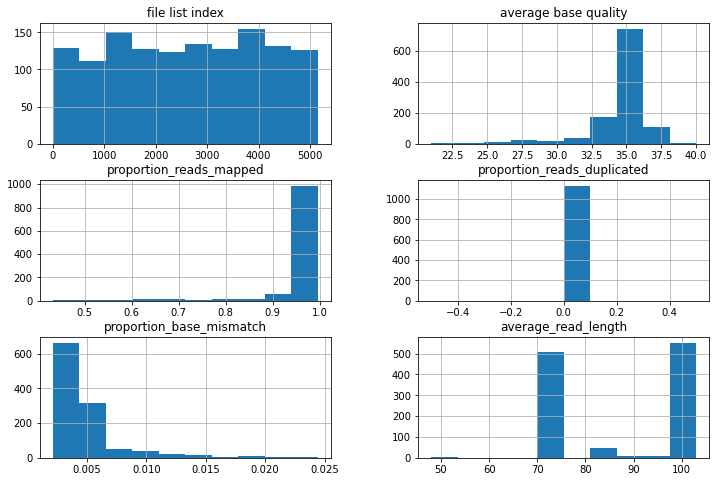

In [5]:
tc.eda_labels(df_samples)

## Plot histograms of the numerical columns of the samples/labels before and after cutoffs are applied, and print out a summary of what was removed

There are 64 bad values in the "average base quality" plot
There are 61 bad values in the "proportion_base_mismatch" plot
There are 54 bad values in the "proportion_reads_mapped" plot
Most bad values are overlapping; taken together, there are 89 bad values
We should likely use these cutoffs to remove the bad samples; this will only remove 6.8% of the data, leaving 1228 good samples
See for example the two generated images: the first is the original data with the cutoffs plotted in red, and the second is the filtered data with the cutoffs applied


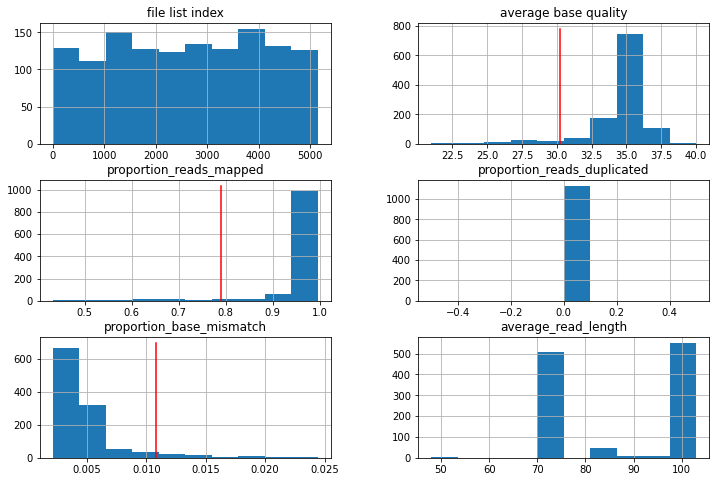

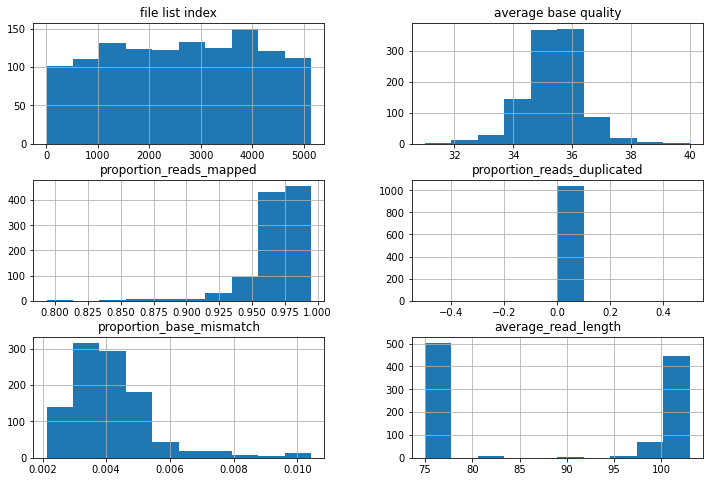

In [6]:
df_samples, indexes_to_keep = tc.remove_bad_samples(df_samples)
df_counts = df_counts.iloc[indexes_to_keep,:]
df_fpkm = df_fpkm.iloc[indexes_to_keep,:]
df_fpkm_uq = df_fpkm_uq.iloc[indexes_to_keep,:]

## Perform exploratory data analysis on the filtered sample labels

Non-numeric columns with all unique values (1228 of them), with sample values:

 . counts file name        068a3608-d761-4ccd-bfe4-d1fb8b9f673b.htseq_counts.txt.gz
 . file id                 5dc34c44-d782-417a-bf37-1ffb01d95f2f
 . entity_submitter_id     TARGET-10-PANTTZ-09B-01R
 . sample id               TARGET-10-PANTTZ-09B

Non-numeric columns with uniform values:

 . contamination_error     None
 . contamination           None
 . state                   released
 . platform                Illumina

Non-numeric columns with non-unique and non-uniform values:

 . project id              9 

TARGET-ALL-P2    518
TARGET-AML       187
TARGET-NBL       143
TARGET-WT        136
TARGET-ALL-P3    135
TARGET-RT         69
TARGET-OS         24
TARGET-CCSK       13
TARGET-ALL-P1      3
Name: project id, dtype: int64 

 . case id                 1099 

TARGET-15-SJMPAL042946    3
TARGET-15-SJMPAL040037    2
TARGET-15-SJMPAL041120    2
TARGET-20-PARTAL          2
TARGET-50-PAJNGH          2
    

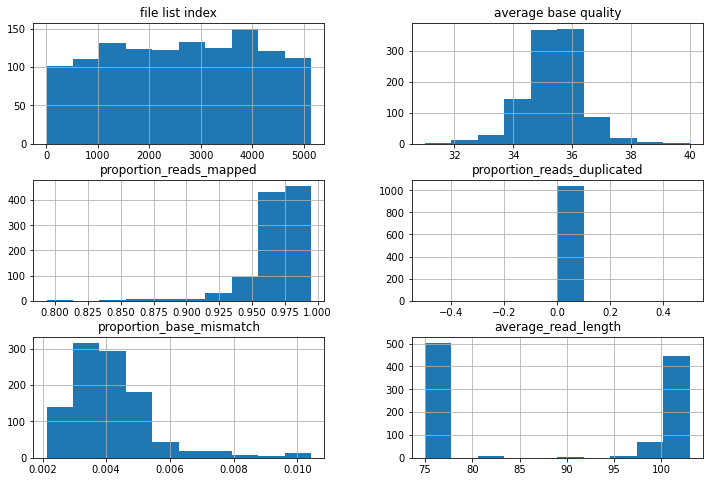

In [7]:
tc.eda_labels(df_samples)

## Print some random data for us to spot-check in the files themselves to manually ensure we have a handle on the data arrays

In [8]:
tc.spot_check_data(df_samples, df_counts, df_fpkm, df_fpkm_uq)

Sample TARGET-10-PARFLV-04A (TARGET-ALL-P2, Recurrent Blood Derived Cancer - Bone Marrow) should have a counts value of 20 for gene ENSG00000272486.1
Sample TARGET-10-PAPECF-09A (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 5205 for gene ENSG00000057608.15
Sample TARGET-10-PAPLUG-09A (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 6 for gene ENSG00000150337.12
Sample TARGET-10-PASPPN-09A (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 12 for gene ENSG00000248896.2
Sample TARGET-10-PANDBX-09B (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a FPKM value of 0.27341691683984937 for gene ENSG00000114455.12
Sample TARGET-10-PASSXJ-03A (TARGET-ALL-P2, Primary Blood Derived Cancer - Peripheral Blood) should have a FPKM value of 4.718389856691642 for gene ENSG00000187522.12
Sample TARGET-20-PANLKB-09A (TARGET-AML, Primary Blood Derived Cancer - 

## Calculate the TPM using the counts and gene lengths
Note I've confirmed sufficient equality using TPM calculation using FPKM and FPKM-UQ

In [9]:
df_tpm = tc.get_tpm(df_counts, annotation_file)

Reading pickle file /data/BIDS-HPC/private/projects/dmi2/data/annotation_dataframe.pkl...


## Add a labels column based on the project id and sample type columns and show the unique values by decreasing frequency

In [10]:
df_samples['label 1'] = df_samples['project id'] + ', ' + df_samples['sample type']
print(df_samples['label 1'].value_counts())

TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow           379
TARGET-NBL, Primary Tumor                                           135
TARGET-WT, Primary Tumor                                            124
TARGET-AML, Primary Blood Derived Cancer - Bone Marrow              119
TARGET-ALL-P3, Primary Blood Derived Cancer - Bone Marrow           113
TARGET-ALL-P2, Primary Blood Derived Cancer - Peripheral Blood       74
TARGET-ALL-P2, Recurrent Blood Derived Cancer - Bone Marrow          64
TARGET-RT, Primary Tumor                                             63
TARGET-AML, Recurrent Blood Derived Cancer - Bone Marrow             40
TARGET-AML, Primary Blood Derived Cancer - Peripheral Blood          26
TARGET-OS, Primary Tumor                                             24
TARGET-CCSK, Primary Tumor                                           13
TARGET-ALL-P3, Recurrent Blood Derived Cancer - Bone Marrow          12
TARGET-ALL-P3, Primary Blood Derived Cancer - Peripheral Blood  

## Run the variance-stabilizing transformation using DESeq2 using this most-detailed set of labels

In [11]:
X1, y1 = tc.run_vst(df_counts, df_samples['label 1'], project_directory)

Reading pickle file /data/BIDS-HPC/private/projects/dmi2/data/datasets/label_1/vst_transformed_data.pkl...


## Create and plot PCA and tSNE analyses using the variance-stabilizing-transformed data from DESeq2

Top 10 PCA explained variance ratios: [0.57111416 0.11740142 0.04599495 0.0355044  0.02593806 0.01694247
 0.01371769 0.01269276 0.00648534 0.00535824]


Text(0.5, 1.0, 'tSNE - variance-stabilizing transformation')

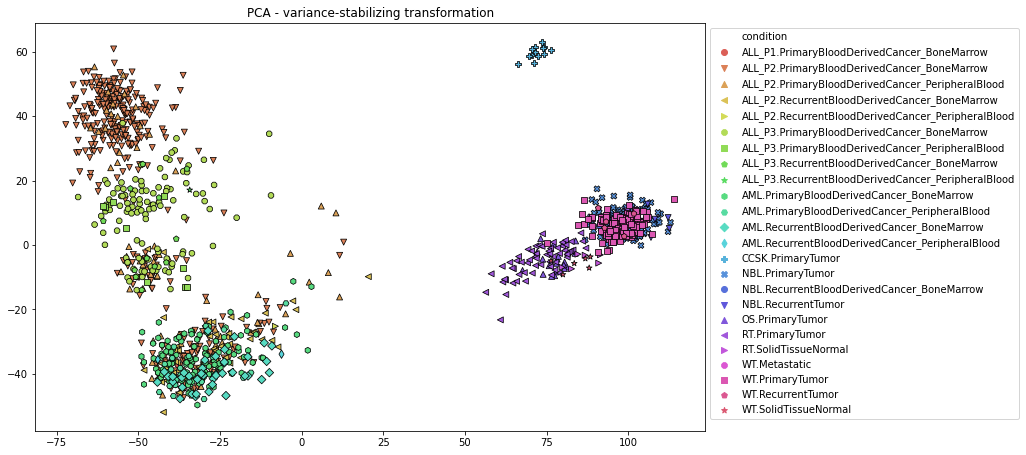

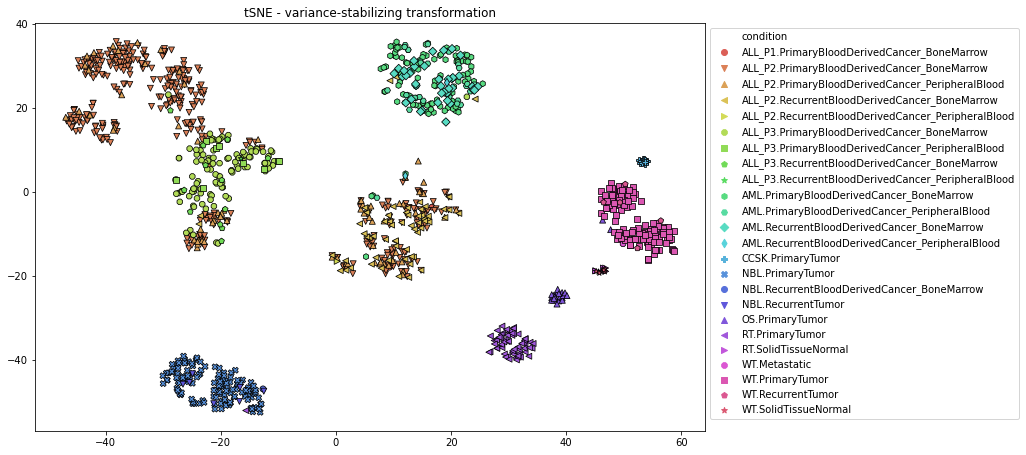

In [62]:
# Perform PCA
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(X1.iloc[:,:500])
#pca_res = pca.fit_transform(X1.iloc[:,:])
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(pca_res, y1)
ax.set_title('PCA - variance-stabilizing transformation')

# Perform tSNE analysis
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(X1.iloc[:,:500])
#tsne_res = tsne.fit_transform(X1.iloc[:,:])
ax = tc.plot_unsupervised_analysis(tsne_res, y1)
ax.set_title('tSNE - variance-stabilizing transformation')

From the above tSNE plot, we find many interesting things, e.g.:

* ALL is spread out in multiple places (all oranges/yellows and early greens), into four main clusters; in particular:
  * ALL/P2/PBDC (both /BM and /PB) is located in three of them
  * ALL/P2/RBDC (i.e., /BM) is basically isolated to one of them
  * ALL/P3 is basically in the fourth cluster
* AML has its own single cluster
* There are some ALL in an AML cluster and vice versa, though the two corresponding clusters are near each other
* CCSK is very tightly clustered
* NBL has its own cluster, with one RT instance that may be misclassified
* OS is tightly clustered, except for two samples in WT, which may indicate that they are misclassified
* Aside from the one possibly misclassified RT, they are all solidly clustered
* WT is clustered together
* The two normal species are very tightly clustered together

## Based on the above observations, make a new set of more sensible labels

See comments in each line in the following code block

In [12]:
df_samples['label 2'] = df_samples['label 1'] # initialize the new label (2) to the original, most-detailed label (1)
df_samples['label 2'][df_samples['label 2'].str.contains('normal', case=False, regex=False)] = 'TARGET-Normal' # set to "TARGET-Normal" any label including "normal" in its original name
df_samples['label 2'] = df_samples['label 2'].str.split(pat=', ', expand=True)[0] # otherwise, just set the label to the project ID (see definition of 'label 1' above)
df_samples['label 2'] = df_samples['label 2'].str.split(pat='-', expand=True)[1] # finally, at the same time, both remove "TARGET-" from the labels and, for ALL, remove "-PX", where X={1,2,3}
print(df_samples['label 2'].value_counts()) # print the final labels counts

ALL       656
AML       187
NBL       143
WT        130
RT         63
OS         24
CCSK       13
Normal     12
Name: label 2, dtype: int64


## Re-label the unsupervised plots above, just as a quick check of our new labeling scheme

In [ ]:
# Define the new labels
y = df_samples['label 2'].copy()
y.index = y.index.str.replace('-', '_')
y = y.loc[y1.index] # order them the same way as the PCA/tSNE results we already calculated

# Redo the plots, with appropriate sorting so that the labels are in alphabetical order
sorting_indexes = y.to_numpy().argsort(axis=0)
ax = tc.plot_unsupervised_analysis(pca_res[sorting_indexes,:], y.iloc[sorting_indexes])
ax.set_title('PCA - variance-stabilizing transformation - with new labels')
ax = tc.plot_unsupervised_analysis(tsne_res[sorting_indexes,:], y.iloc[sorting_indexes])
ax.set_title('tSNE - variance-stabilizing transformation - with new labels')

Note that had we not previously plotted the most detailed set of labels, we would have been left forever wondering why the two distinct clusters of AML data.

## Now actually run the variance-stabilizing transformation using DESeq2 on the re-labeled dataset

In [13]:
X2, y2 = tc.run_vst(df_counts, df_samples['label 2'], project_directory)

Reading pickle file /data/BIDS-HPC/private/projects/dmi2/data/datasets/label_2/vst_transformed_data.pkl...


## Run PCA and tSNE on the new dataset

Top 10 PCA explained variance ratios: [0.57089244 0.11708428 0.04639597 0.03517564 0.02593218 0.01685384
 0.01393864 0.01273613 0.00649362 0.00543036]


Text(0.5, 1.0, 'tSNE - variance-stabilizing transformation')

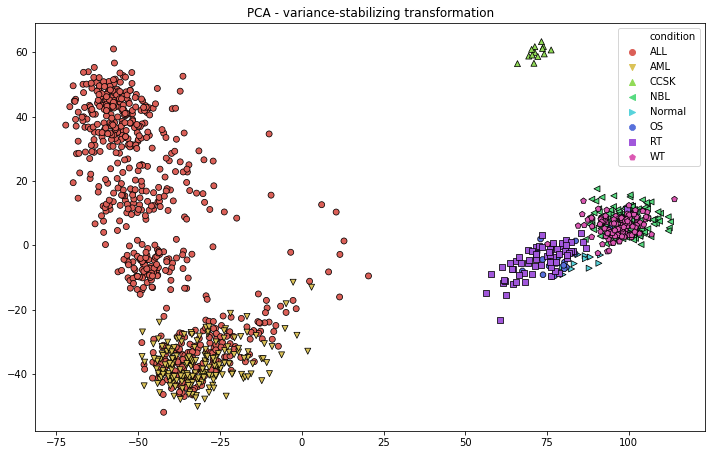

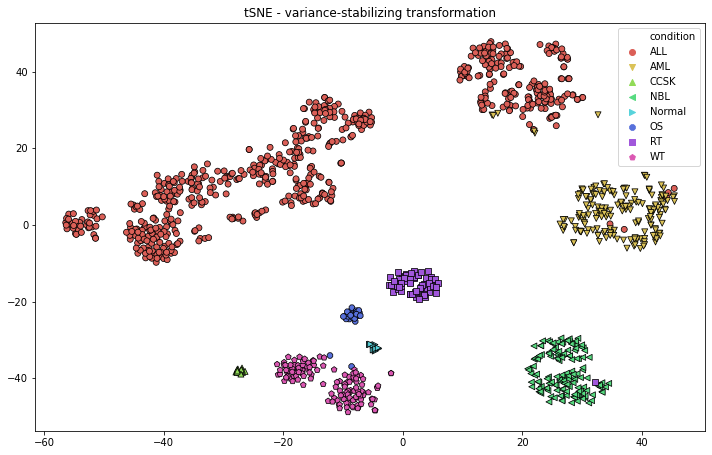

In [58]:
# Perform PCA
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(X2.iloc[:,:500])
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(pca_res, y2)
ax.set_title('PCA - variance-stabilizing transformation')

# Perform tSNE analysis
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(X2.iloc[:,:500])
ax = tc.plot_unsupervised_analysis(tsne_res, y2)
ax.set_title('tSNE - variance-stabilizing transformation')

## Create a figure helping to explore the extent of sampling each unique label in the dataset (i.e., each group)

In [ ]:
fig = tc.explore_sample_size(X2, y2, tsne_res, n_range=range(100,601,100))
fig.savefig(os.path.join(project_directory, 'data', 'exploring_sample_size_100_601_100.png'), facecolor='w', dpi=150)

## Calculate the data for a study of how the accuracy on the entire dataset (which is our test set) depends on the bootstrap sampling size from each group in the the entire dataset (yes, the test set!)

Note that this is sort of what we're forced to do given the small size of the minority classes, though we see the accuracy is still so good that we can probably do a "real" study (i.e., with a training and test set)

Reading pickle file /data/BIDS-HPC/private/projects/dmi2/data/accuracy_vs_sampling_size.pkl...


Text(0.5, 1.0, 'Overall accuracy on entire dataset')

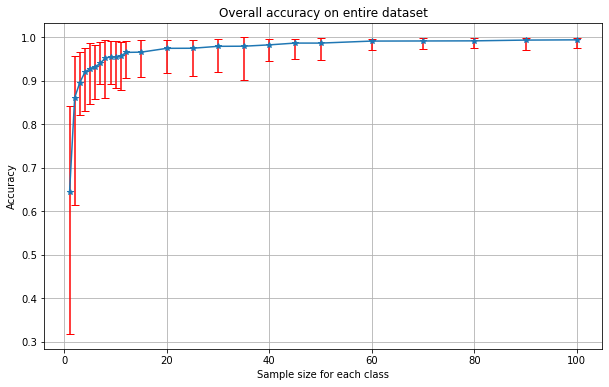

In [63]:
accuracies, possible_n = tc.calculate_whole_dataset_accuracy_vs_bootstrap_sampling_size(X2, y2, project_directory, ntrials=50)

import matplotlib.pyplot as plt
import numpy as np
means = accuracies.mean(axis=0)
_, ax = plt.subplots(figsize=(10,6))
_ = ax.errorbar(x=possible_n, y=means, yerr=np.row_stack((means-accuracies.min(axis=0), accuracies.max(axis=0)-means)), fmt='*-', ecolor='red', capsize=4)
ax.grid(True)
ax.set_xlabel('Sample size for each class')
ax.set_ylabel('Accuracy')
ax.set_title('Overall accuracy on entire dataset')

# Scratch